## Business Understanding
What are people's concerns in review ?

## Data understanding
In order to approach this question, I need tag the Noun in each sentence.However, there also are some terms which may be related to the names and they are useless. A classification of these words will be necessary.
words classification will be based on the words embedding

In [1]:
#import necessary libs
import pandas as pd
import numpy as np
from numpy import linalg as LA

import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
#refer to https://www.kaggle.com/residentmario/sentiment-analysis-and-collocation-of-reviews
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

import matplotlib.pyplot as plt

import gensim
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import codecs
import itertools as it

import spacy 
#for spacy refer to 
#https://github.com/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb

# to classify clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

C:\Users\zzguk\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Data Prepare

In [2]:
#read data and check the data
df_reviews = pd.read_csv('boston/reviews.csv')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


### Drop NAN and Choose English Language

In [3]:
#there are several languages
#we only intereted in English
def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [4]:
#drop na
df_reviews_no_na = df_reviews.dropna().copy() 

In [5]:
#create another columns for language
df_reviews_no_na['language'] = df_reviews_no_na['comments'].apply(get_language)

In [6]:
#this take a long time to run , we save it
df_reviews_no_na.to_csv('boston/reviews_no_na_add_language_type.csv',index=False)

In [3]:
#let's load file
df_reviews_lang = pd.read_csv('boston/reviews_no_na_add_language_type.csv')

In [3]:
#check how many types
df_reviews_lang['language'].value_counts()

english        64001
french          1285
arabic          1050
spanish          630
german           535
italian          191
dutch            184
portuguese       101
azerbaijani       99
danish            58
russian           27
swedish           18
norwegian         16
greek              8
romanian           7
finnish            5
turkish            3
hungarian          3
indonesian         1
Name: language, dtype: int64

In [22]:
#most are english, we only intereted in english
df_review_english = df_reviews_lang[df_reviews_lang['language']=='english'].copy()

### An example of spacy

In [21]:
#let's clean the data
#we will split each reviews into sentence and then tag the words
#need to run  python -m spacy download en
nlp = spacy.load('C:\\Users\\zzguk\\Anaconda3\\Lib\\site-packages\\en_core_web_sm\\en_core_web_sm-2.0.0')

In [23]:
#spacy can parse the text and can tag the words
#let's see some example

sample_parsed_review = nlp(df_review_english['comments'][0])

In [24]:
print(sample_parsed_review)

My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)


In [25]:
#split the review by sentences
for num, sentence in enumerate(sample_parsed_review.sents):
    print('Sentence {}:'.format(num+1))
    print(sentence)
    print()

Sentence 1:
My stay at islam's place was really cool!

Sentence 2:
Good location, 5min away from subway, then 10min from downtown.

Sentence 3:
The room was nice, all place was clean.

Sentence 4:
Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)



In [26]:
#entity
#show entity
for num,entity in enumerate(sample_parsed_review.ents):
    print('Entity {}:'.format(num+1),entity,'-',entity.label_)

Entity 1: 5min - CARDINAL
Entity 2: 10min - CARDINAL
Entity 3: Islam - ORG
Entity 4: last minute - TIME


In [27]:
for token in sample_parsed_review:
    print(token.lemma_)

-PRON-
stay
at
islam
's
place
be
really
cool
!
good
location
,
5min
away
from
subway
,
then
10min
from
downtown
.
the
room
be
nice
,
all
place
be
clean
.
islam
manage
pretty
well
-PRON-
arrival
,
even
if
-PRON-
be
last
minute
;)
i
do
recommand
this
place
to
any
airbnb
user
:)


In [28]:
# we can tag each words
token_text = [token.orth_ for token in sample_parsed_review]
token_pos = [token.pos_ for token in sample_parsed_review]
list(zip(token_text,token_pos))

[('My', 'ADJ'),
 ('stay', 'NOUN'),
 ('at', 'ADP'),
 ('islam', 'NOUN'),
 ("'s", 'PART'),
 ('place', 'NOUN'),
 ('was', 'VERB'),
 ('really', 'ADV'),
 ('cool', 'ADJ'),
 ('!', 'PUNCT'),
 ('Good', 'ADJ'),
 ('location', 'NOUN'),
 (',', 'PUNCT'),
 ('5min', 'NOUN'),
 ('away', 'ADV'),
 ('from', 'ADP'),
 ('subway', 'NOUN'),
 (',', 'PUNCT'),
 ('then', 'ADV'),
 ('10min', 'VERB'),
 ('from', 'ADP'),
 ('downtown', 'NOUN'),
 ('.', 'PUNCT'),
 ('The', 'DET'),
 ('room', 'NOUN'),
 ('was', 'VERB'),
 ('nice', 'ADJ'),
 (',', 'PUNCT'),
 ('all', 'DET'),
 ('place', 'NOUN'),
 ('was', 'VERB'),
 ('clean', 'ADJ'),
 ('.', 'PUNCT'),
 ('Islam', 'PROPN'),
 ('managed', 'VERB'),
 ('pretty', 'ADV'),
 ('well', 'ADV'),
 ('our', 'ADJ'),
 ('arrival', 'NOUN'),
 (',', 'PUNCT'),
 ('even', 'ADV'),
 ('if', 'ADP'),
 ('it', 'PRON'),
 ('was', 'VERB'),
 ('last', 'ADJ'),
 ('minute', 'NOUN'),
 (';)', 'PUNCT'),
 ('i', 'PRON'),
 ('do', 'VERB'),
 ('recommand', 'ADV'),
 ('this', 'DET'),
 ('place', 'NOUN'),
 ('to', 'ADP'),
 ('any', 'DET'),
 (

In [29]:
token_entity_type = [token.ent_type_ for token in sample_parsed_review]
token_entity_iob = [token.ent_iob_ for token in sample_parsed_review]


In [35]:
#let's make them a data frame
tmp_list = list(zip(token_text, token_entity_type, token_entity_iob))
pd.DataFrame(tmp_list,
             columns=['token_text', 'entity_type', 'inside_outside_begin']).head(10)

,token_text,entity_type,inside_outside_begin
0,My,,O
1,stay,,O
2,at,,O
3,islam,,O
4,'s,,O
5,place,,O
6,was,,O
7,really,,O
8,cool,,O
9,!,,O


In [34]:
#make dateframe
token_lemma = [token.lemma_ for token in sample_parsed_review]
token_shape = [token.shape_ for token in sample_parsed_review]
pd.DataFrame(list(zip(token_text, token_lemma, token_shape)),
             columns=['token_text', 'token_lemma', 'token_shape']).head()

,token_text,token_lemma,token_shape
0,My,-PRON-,Xx
1,stay,stay,xxxx
2,at,at,xx
3,islam,islam,xxxx
4,'s,'s,'x


In [37]:
token_entity_type = [token.ent_type_ for token in sample_parsed_review]
token_entity_iob = [token.ent_iob_ for token in sample_parsed_review]

pd.DataFrame(list(zip(token_text, token_entity_type, token_entity_iob)),
             columns=['token_text', 'entity_type', 'inside_outside_begin']).head(10)

,token_text,entity_type,inside_outside_begin
0,My,,O
1,stay,,O
2,at,,O
3,islam,,O
4,'s,,O
5,place,,O
6,was,,O
7,really,,O
8,cool,,O
9,!,,O


In [38]:
#here is summary of the example
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in sample_parsed_review]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
df.head(10)

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,My,-20.0,,,,,Yes
1,stay,-20.0,,,,,Yes
2,at,-20.0,Yes,,,,Yes
3,islam,-20.0,,,,,Yes
4,'s,-20.0,,,,,Yes
5,place,-20.0,,,,,Yes
6,was,-20.0,Yes,,,,Yes
7,really,-20.0,Yes,,,,Yes
8,cool,-20.0,,,,,Yes
9,!,-20.0,,Yes,,,Yes


### The following procedure will be performed
- Split each reviews to sentences
- Tag the words in sentence
- remove punctuations, space, lower the words
- perform bigrams twice to get trigrams


In [6]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

In [7]:
def punct_space_stop(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space or token.is_stop

In [57]:

def lemmatized_sentence_corpus():
    #for each review, split by sentences
    #then we tag each word
    #we will remove punctuation,whitespace
    #for each word we will apppend pos tag on it
    for rev in df_review_english['comments']:
        parsed_rev = nlp(rev)
        for sent in parsed_rev.sents:
            yield u' '.join([token.lemma_+'_'+token.pos_ for token in sent 
                             if not punct_space(token)])

In [58]:
#let's put all sentence into a file 
#it take some times
if False:
    with codecs.open('review_sentences_in_all_add_pos.txt','w',encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus():
            f.write(sentence+'\n')

In [59]:
reveiw_sentences = LineSentence('review_sentences_in_all_add_pos.txt')

In [60]:
#check the first 5 sentence
ct=0
for sent in reveiw_sentences:
    print(sent)
    ct += 1
    if ct>5:
        break

['-PRON-_ADJ', 'stay_NOUN', 'at_ADP', 'islam_NOUN', "'s_PART", 'place_NOUN', 'be_VERB', 'really_ADV', 'cool_ADJ']
['good_ADJ', 'location_NOUN', '5min_NOUN', 'away_ADV', 'from_ADP', 'subway_NOUN', 'then_ADV', '10min_VERB', 'from_ADP', 'downtown_NOUN']
['the_DET', 'room_NOUN', 'be_VERB', 'nice_ADJ', 'all_DET', 'place_NOUN', 'be_VERB', 'clean_ADJ']
['islam_PROPN', 'manage_VERB', 'pretty_ADV', 'well_ADV', '-PRON-_ADJ', 'arrival_NOUN', 'even_ADV', 'if_ADP', '-PRON-_PRON', 'be_VERB', 'last_ADJ', 'minute_NOUN', 'i_PRON', 'do_VERB', 'recommand_ADV', 'this_DET', 'place_NOUN', 'to_ADP', 'any_DET', 'airbnb_ADJ', 'user_NOUN']
['great_ADJ', 'location_NOUN', 'for_ADP', 'both_DET', 'airport_NOUN', 'and_CCONJ', 'city_NOUN', 'great_ADJ', 'amenity_NOUN', 'in_ADP', 'the_DET', 'house_NOUN', 'plus_CCONJ']
['islam_PROPN', 'be_VERB', 'always_ADV', 'very_ADV', 'helpful_ADJ', 'even_ADV', 'though_ADP', '-PRON-_PRON', 'be_VERB', 'away_ADV']


In [61]:
#first let's make a bigrams
#write to a txt file
#it will take some time
if False:
    bigram_model = Phrases(reveiw_sentences)
    bigram_model.save('bigram_review_all_add_pos')
bigram_model = Phrases.load('bigram_review_all_add_pos')

In [64]:
#write the bigram to a text file, since it takes some time
if False:
    with codecs.open('bigram_review_sentences_all_add_pos.txt','w',encoding='utf_8') as f:
        for sentence in reveiw_sentences:
            bigram_sent = u' '.join(bigram_model[sentence])
            f.write(bigram_sent + '\n')

In [68]:
#reload bigram sentences
rev_bigram_sentences = LineSentence('bigram_review_sentences_all_add_pos.txt')

In [66]:
#let's do it again to get trigram and save the model
if False:
    trigram_model = Phrases(rev_bigram_sentences)
    trigram_model.save('trigram_review_all_add_pos')
trigram_model = Phrases.load('trigram_review_all_add_pos')

In [70]:
#let's save the trigram sentences since it takes some time
if False:
    with codecs.open('trigram_review_sentences_all_add_pos.txt','w',encoding='utf_8') as f:
        for sentence in rev_bigram_sentences:
            trigram_sent = u' '.join(trigram_model[sentence])
            f.write(trigram_sent + '\n')

In [5]:
#load the trigram sentences
rev_trigram_sentences = LineSentence('trigram_review_sentences_all_add_pos.txt')

### Perform word embedding

In [6]:
#words embedding
#we also save it for later use
#word2vector
if False:
    review_sentence2vec = Word2Vec(rev_trigram_sentences,size=100,window=5,
                                  min_count=20,sg=1,workers=4)
    review_sentence2vec.save('review_trigram_sentence_w2v_model_add_pos')
    
    #perform another 11 epochs of training
    for i in range(1,12):
        review_sentence2vec.train(rev_trigram_sentences,
                                  total_examples=review_sentence2vec.corpus_count,
                                  epochs=review_sentence2vec.iter)
        review_sentence2vec.save('review_trigram_sentence_w2v_model_add_pos')

review_sentence2vec = Word2Vec.load('review_trigram_sentence_w2v_model_add_pos')
review_sentence2vec.init_sims()

print(u'{} training epochs so far.'.format(review_sentence2vec.train_count))

12 training epochs so far.


In [7]:
#get the words for embeding
#and the index to words
words_embeding = review_sentence2vec.wv.syn0
array_index2words = np.array(review_sentence2vec.wv.index2word)

C:\Users\zzguk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [8]:
#check the number of words
print(u'{:,} terms in the food2vec vocabulary.'.format(len(review_sentence2vec.wv.vocab)))

6,070 terms in the food2vec vocabulary.


In [9]:
#let's check if the embeding work or not
review_sentence2vec.wv.most_similar(positive=['airport_NOUN'],topn=10)

[('airport_PROPN', 0.7683822512626648),
 ('logan_PROPN', 0.747701108455658),
 ('logan_PROPN_airport_NOUN', 0.7425930500030518),
 ('logan_PROPN_airport_PROPN', 0.7227504253387451),
 ('train_NOUN_station_NOUN', 0.6893695592880249),
 ('airport_NOUN_shuttle_NOUN', 0.6815669536590576),
 ('bus_NOUN_station_NOUN', 0.6712270975112915),
 ('train_NOUN', 0.6533764004707336),
 ('shuttle_NOUN', 0.6418344974517822),
 ('blue_ADJ_line_NOUN', 0.641494870185852)]

In [10]:
review_sentence2vec.wv.most_similar(positive=['bed_NOUN'],topn=10)

[('mattress_NOUN', 0.8054273128509521),
 ('sofa_NOUN', 0.7524084448814392),
 ('sofa_NOUN_bed_NOUN', 0.7511492967605591),
 ('queen_NOUN_bed_NOUN', 0.7434046268463135),
 ('soft_ADJ', 0.7267969846725464),
 ('futon_NOUN', 0.7207096219062805),
 ('couch_NOUN', 0.7064340710639954),
 ('pillow_NOUN', 0.6834216117858887),
 ('bedding_NOUN', 0.6530532836914062),
 ('queen_NOUN_size_NOUN_bed_NOUN', 0.6473265886306763)]

In [11]:
review_sentence2vec.wv.most_similar(positive=['tv_NOUN'],topn=10)

[('cable_NOUN', 0.8475870490074158),
 ('netflix_PROPN', 0.7817489504814148),
 ('cable_NOUN_tv_NOUN', 0.7504919767379761),
 ('television_NOUN', 0.750319242477417),
 ('internet_NOUN', 0.7477015256881714),
 ('wifi_NOUN', 0.7263410091400146),
 ('wifi_PROPN', 0.7077149152755737),
 ('wireless_ADJ_internet_NOUN', 0.6910890936851501),
 ('big_ADJ_screen_NOUN_tv_NOUN', 0.6858027577400208),
 ('roku_PROPN', 0.6745760440826416)]

In [12]:
review_sentence2vec.wv.most_similar(positive=['neighbor_NOUN'],topn=10)

[('neighbour_NOUN', 0.663318395614624),
 ('hear_VERB', 0.6364037990570068),
 ('upstairs_ADJ_neighbor_NOUN', 0.5978832244873047),
 ('yell_VERB', 0.580481767654419),
 ('loud_ADJ_music_NOUN', 0.5638773441314697),
 ('people_NOUN', 0.5574698448181152),
 ('loud_ADJ', 0.5477060079574585),
 ('other_ADJ_resident_NOUN', 0.5327269434928894),
 ('other_ADJ_guest_NOUN', 0.5304839611053467),
 ('could_VERB_hear_VERB', 0.5285017490386963)]

In [13]:
review_sentence2vec.wv.most_similar(positive=['host_NOUN'],topn=10)

[('hostess_NOUN', 0.8013387322425842),
 ('gracious_ADJ_host_NOUN', 0.7058875560760498),
 ('hospitable_ADJ', 0.6423259377479553),
 ('kind_ADJ', 0.6296424865722656),
 ('communicator_NOUN', 0.6295914053916931),
 ('host-_NOUN', 0.6244525909423828),
 ('host_PROPN', 0.604840099811554),
 ('an_DET_exceptional_ADJ_host_NOUN', 0.604225754737854),
 ('friendly_ADJ', 0.595440149307251),
 ('considerate_ADJ', 0.5935953855514526)]

In [14]:
review_sentence2vec.wv.most_similar(positive=['jp_PROPN'],topn=10)

[('jamaica_PROPN_plain_PROPN', 0.8697308897972107),
 ('jamaica_PROPN_plains_PROPN', 0.7174323797225952),
 ('allston_PROPN', 0.6661891937255859),
 ('south_PROPN_end_PROPN', 0.6365325450897217),
 ('brighton_PROPN', 0.6084582209587097),
 ('south_PROPN_boston_PROPN', 0.6076585054397583),
 ('charlestown_PROPN', 0.5943469405174255),
 ('boston_PROPN', 0.5908483266830444),
 ('south_ADJ_end_NOUN', 0.5871374607086182),
 ('mission_PROPN_hill_PROPN', 0.5770779848098755)]

In [15]:
review_sentence2vec.wv.most_similar(positive=['bad_ADJ'],topn=10)

[('terrible_ADJ', 0.6605699062347412),
 ('negative_ADJ', 0.6107746362686157),
 ('awful_ADJ', 0.5961323976516724),
 ('unpleasant_ADJ', 0.5583287477493286),
 ('notice_VERB', 0.5417041778564453),
 ('uncomfortable_ADJ', 0.5277208089828491),
 ('affect_VERB', 0.5218985080718994),
 ('positive_ADJ', 0.5090909004211426),
 ('nothing_NOUN_bad_ADJ', 0.5086135864257812),
 ('disappointed_ADJ', 0.5084785223007202)]

In [16]:
review_sentence2vec.wv.most_similar(positive=['excellent_ADJ'],topn=10)

[('superb_ADJ', 0.7611247301101685),
 ('great_ADJ', 0.720699667930603),
 ('fantastic_ADJ', 0.7131500244140625),
 ('outstanding_ADJ', 0.6796425580978394),
 ('fabulous_ADJ', 0.6632729768753052),
 ('terrific_ADJ', 0.6558611392974854),
 ('an_DET_excellent_ADJ', 0.6371711492538452),
 ('amazing_ADJ', 0.6347875595092773),
 ('awesome_ADJ', 0.6259496808052063),
 ('brilliant_ADJ', 0.6223203539848328)]

In [17]:
review_sentence2vec.wv.most_similar(positive=['close_ADJ'],topn=10)

[('close_ADV', 0.8644901514053345),
 ('near_ADJ', 0.6760656833648682),
 ('walk_VERB_distance_NOUN', 0.6739990711212158),
 ('near_ADP', 0.6636294722557068),
 ('close_NOUN', 0.6610522270202637),
 ('close_ADJ_proximity_NOUN', 0.6480978727340698),
 ('within_ADP_walking_NOUN_distance_NOUN', 0.6418805718421936),
 ('short_ADJ_walk_NOUN', 0.6377217173576355),
 ('within_ADP_walk_VERB_distance_NOUN', 0.6333810091018677),
 ('right_ADV_next_ADV', 0.633271336555481)]

In [18]:
#it works as expected
review_sentence2vec.wv.most_similar(positive=['wifi_NOUN'],topn=10)

[('wifi_PROPN', 0.841977596282959),
 ('internet_NOUN', 0.8368513584136963),
 ('wi_NOUN_fi_NOUN', 0.7333458065986633),
 ('tv_NOUN', 0.7263410687446594),
 ('cable_NOUN_tv_NOUN', 0.7076839208602905),
 ('wireless_ADJ', 0.6673827171325684),
 ('wi_PROPN_fi_PROPN', 0.6610671281814575),
 ('wireless_ADJ_internet_NOUN', 0.6563978791236877),
 ('wireless_NOUN', 0.6461172103881836),
 ('wifi_VERB', 0.645552396774292)]

## Classifiy words:
Use kmeans to classifiy these words and then check each cluster

In [10]:
def average_vs_k(indexes):
    #indexes: a list of index
    #cluster the embeding words 
    #in indexes
    Ws=words_embeding[indexes]
    scores = []
    for nclus in range(4,31):
        km = KMeans(n_clusters=nclus,init='random',n_init=10,random_state=0,n_jobs=-1)
        km.fit(Ws)
        w_predict = km.predict(Ws)
        centers = km.cluster_centers_
        distance = 0
        for i in range(nclus):
            distance += np.sum(np.sqrt(np.sum(np.power(Ws[w_predict==i]-centers[i],2),axis=1)))
        distance /= Ws.shape[0]
        scores.append(distance)
    plt.plot(list(range(4,31)),scores,linestyle='--', marker='o', color='b')

In [11]:
#get freq for each word
words_freq={}
for sent in rev_trigram_sentences:
    for w in sent:
        if w in words_freq:
            words_freq[w] += 1
        else:
            words_freq[w] = 1

In [12]:
#get Nouns index
noun_index=[]
for i in range(array_index2words.shape[0]):
    if 'NOUN' in array_index2words[i] or 'PROPN' in array_index2words[i]:
        noun_index.append(i)

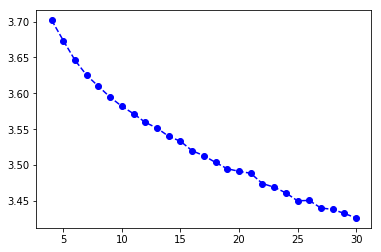

In [13]:
#the average dist vs number of clusters
average_vs_k(noun_index)

In [14]:
#I decide to use 19 clusters, since there is a turnover
bt_km = KMeans(n_clusters=19,random_state=0,n_jobs=-1)
bt_km.fit(words_embeding[noun_index])
bt_predict = bt_km.predict(words_embeding[noun_index])

In [18]:
#let's check terms in each clusters,
#each term in cluster is ordered by counts
cluster_counts = []
ignore_clus=[0,3,4,8,9,10]
for i in range(19):
    words = array_index2words[noun_index][bt_predict==i]
    print("cluster ",i)
    total_count=0
    sorted_words=[]
    for w in words:
        total_count += words_freq[w]
        sorted_words.append((w,words_freq[w]))
    if i not in ignore_clus:
        cluster_counts.append((i,total_count))
    sorted_words.sort(reverse=True,key=lambda x:x[1])
    print(sorted_words[0:15])
    print("total count: ",total_count)

cluster  0
[('boston_PROPN', 28819), ('stay_NOUN', 18811), ('experience_NOUN', 6977), ('day_NOUN', 5201), ('thank_NOUN', 4451), ('trip_NOUN', 3353), ('weekend_NOUN', 1628), ('visit_NOUN', 1558), ('week_NOUN', 1457), ('anyone_NOUN', 1427), ('next_ADJ_time_NOUN', 1396), ('first_ADJ_time_NOUN', 1221), ('an_DET_automate_VERB_posting_NOUN', 966), ('future_NOUN', 708), ('anyone_NOUN_look_VERB', 441)]
total count:  90358
cluster  1
[('restaurant_NOUN', 7394), ('shop_NOUN', 2017), ('food_NOUN', 2016), ('bar_NOUN', 1615), ('corner_NOUN', 1199), ('dinner_NOUN', 757), ('cafe_NOUN', 745), ('store_NOUN', 705), ('block_NOUN', 645), ('grocery_NOUN_store_NOUN', 626), ('whole_PROPN_foods_PROPN', 510), ('meal_NOUN', 509), ('supermarket_NOUN', 480), ('coffee_NOUN_shop_NOUN', 465), ('grocery_NOUN', 424)]
total count:  27202
cluster  2
[('town_NOUN', 2122), ('car_NOUN', 1888), ('work_NOUN', 914), ('conference_NOUN', 765), ('host_NOUN_cancel_VERB_this_DET', 743), ('end_NOUN', 715), ('cambridge_PROPN', 503),

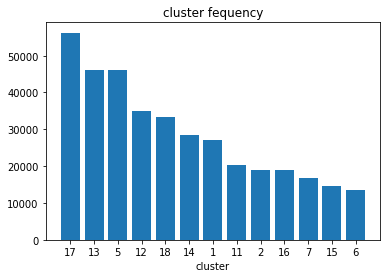

In [16]:
#let's plot the counts of each cluster
#we removed 0,3,4,8,9,10 clusters, since they don't give us more detail information
cluster_counts.sort(reverse = True,key=lambda x:x[1])
indexes=[]
heights=[]
for i in cluster_counts:
    indexes.append(str(i[0]))
    heights.append(i[1])
plt.bar(indexes,heights)
plt.title('cluster fequency')
plt.xlabel('cluster');

In [17]:
#check the cluster 9
array_index2words[noun_index][bt_predict==9]

array(['place_NOUN', 'apartment_NOUN', 'location_NOUN', 'room_NOUN',
       'house_NOUN', 'everything_NOUN', 'neighborhood_NOUN', 'home_NOUN',
       'area_NOUN', 'lot_NOUN', 'city_NOUN', 'space_NOUN', 'studio_NOUN',
       'plenty_NOUN', 'hotel_NOUN', 'neighbourhood_NOUN', 'amenity_NOUN',
       'view_NOUN', 'spot_NOUN', 'part_NOUN', 'access_NOUN',
       'accommodation_NOUN', 'price_NOUN', 'condo_NOUN',
       'easy_ADJ_access_NOUN', 'heart_NOUN', 'apartment_PROPN',
       'value_NOUN', 'jamaica_PROPN_plain_PROPN', 'option_NOUN',
       'jp_PROPN', 'appartment_NOUN', 'room_PROPN', 'travel_NOUN',
       'rest_NOUN', 'exactly_ADV_what_NOUN', 'use_NOUN', 'front_NOUN',
       'middle_NOUN', 'choice_NOUN', 'facility_NOUN', 'site_NOUN',
       'ton_NOUN', 'boston_NOUN', 'dining_NOUN', 'loft_NOUN',
       'breeze_NOUN', 'garden_NOUN', 'house_PROPN', 'comfort_NOUN',
       'location_PROPN', 'character_NOUN', 'charlestown_PROPN',
       'convenience_NOUN', 'fun_NOUN', 'sightseeing_NOUN', 'his

## Summary:
Many terms are not single and has adjective next to it (we are doing trigrams).Besides, some terms like smile, briefly can give us some hints.From these terms, we learn something about the cluster.For example, in cluster 5, host appears a lot. Besides, we also see terms like hospitalit,gracious and smile. We can concluded this cluster is about the impression of the host.Besides, we also see terms like sweet_dog, cute cats. We then conclude friendly pets can impress guests.   

### cluster description
cluster 0 : looks like the overall experience(like first time, first air bnb,real pleasure and so on) <br>
cluster 1 : mostly related to the food,drink,grocery, pharmacy and also some entertaiment. <br>
cluster 2 : related to the parking, campus. This type of review may come from students <br>
cluster 3:  people's name. <br>
cluster 4:  this cluster may be the description of the owner or guest like family, wife, son <br>
cluster 5:  Something about the host like kindness , friendliness <br>
cluster 6:  living enviroment, like noise, cold, smoke air condition,roommate and so on. If we check the terms in this cluster, many terms is related to the noise like construction noise,AC noise, stree noise. <br> 
cluster 7:  something related to the toiletry and washing.like towel, shampoo, laundry and so on <br>
cluster 8: people's name <br>
cluster 9: overall review of house, like great location,quiet residential area,reasonable price and so on.<br>
cluster 10: This cluster is hard to determine, we will ignore this  <br>
cluster 11: something about the building,like door,entrance,ladder,elevator and so on. <br>
cluster 12: the communication,instruction of the host.For example, an excellent communicator, constant communication,quick response and so on <br>
cluster 13: bedroom, bathroom,kitchen and amenities.For example,internet, mattress,chair,sofa and so on <br>
cluster 14: park, tourist attraction <br>
cluster 15: some guide and instruction for the house <br>
cluster 16: breakfast,food,drink, home made food <br>
cluster 17: downtown,airport ,transportation <br>
cluster 18: easy check int and check out. like early arrival, midnight,early morning and so on.
### what can we learn from this
We will ignore cluster 0,3,4,8,10. Because they can't provide detail information on the living experience.Cluster 9 will also be excluded,it provides some information like price,but most of terms don't give us specific aspect of why the place is good or bad. We will count the freqency of each cluster to extract the information of people's concerns.


From the cluster frequency plot, we can find which cluster is more important. However, here I try to group these clusters into several aspects and also include the counts.
* Host (147,994) : 
  + Cluster 5 (45982): As host, you should always give your guests good impression, like kindness, gracious. If you have pets, make sure they are cute and friendly.
  + Cluster 12 (35069): You should be easily reached or contacted.The responds should be fast and the instruction should be clear.
  + Cluster 18 (33463): The check in and out should be easy and flexible. For example, if guests arrive early or late. Besides, the reservation and  cancellation should be convenient.
  + Cluster 16 (18851): Try to provide breakfast,drink(wine,coffee,tea) and some delicious home made food. 
  + Cluster 15 (14629): Give necessary imforamtion: like instruction, tour guidance and tips.
* Amenities and living environment (96,909):
  + Cluster 13 (46178): TV, internet, comfortable beds,kitchen and so on
  + Cluster 7 (16886): This cluster is also related to the amenities, but more specific. It is about the washing like shower,laundry. They are very important for tourist.I think host should provide good shower environment and convenient laundary.
  + Cluster 11 (20235): house condition like door, stair, entrance, elevator. Should make them convenient for guest to carray their luggage.  
  + Cluster 6 (13610): This cluster is about noisy like machine noisy, street noisy, roommate noisy. Make sure guest get quiet environment.
* Location (130,801): 
  + Cluster 17 (56235): convenient transportation. Can easily get to downtown and airport.
  + Cluster 1  (27202): have restaurant, market, pharmacy. 
  + Cluster 14 (28333): Park, famous attraction
  + Cluster 2  (19031): Parking, university, convention center
